In [1]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

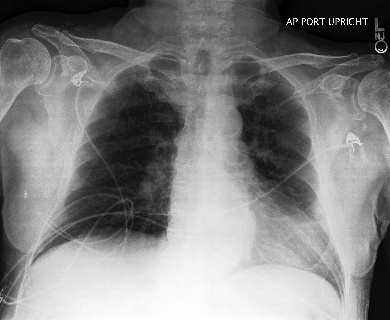

In [4]:
image = Image.open("ChexPert/data/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg").convert("RGB")
image

In [5]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

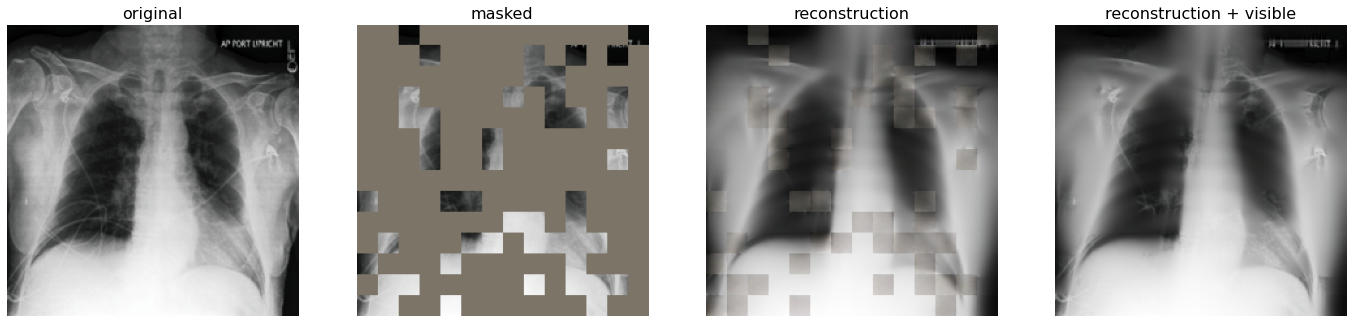

In [7]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("vit-mae-chexpert/")

visualize(pixel_values, model)

In [10]:
tmp = {}

In [33]:
tmp = {}
tmp["predictions"] = np.random.normal(size=(6,6))
tmp["predictions"][2,2] = 7
tmp["label_ids"] = np.identity(6)

from types import SimpleNamespace
tmp = SimpleNamespace(**tmp)
tmp

namespace(predictions=array([[-0.00988124, -0.83455636, -0.75807423, -0.61799596,  1.50145253,
                              -0.18960602],
                             [ 0.16493252,  1.26412594, -0.27851716,  0.89257239, -0.05951174,
                              -1.25416317],
                             [-0.02569262, -0.49245948,  7.        ,  0.72813373,  0.23885433,
                               1.01450472],
                             [ 1.46040386, -2.08180134,  0.1544767 ,  0.58505558, -0.50312328,
                               0.93105176],
                             [-0.47367266, -0.57935533, -1.67506651, -0.18303471,  0.57413575,
                              -0.58172175],
                             [-0.79856659,  0.86243345, -0.91074373,  0.65291809, -1.85461964,
                              -0.64641482]]),
          label_ids=array([[1., 0., 0., 0., 0., 0.],
                           [0., 1., 0., 0., 0., 0.],
                           [0., 0., 1., 0., 0., 0.],
     

In [34]:
from utils import compute_metrics

In [35]:
compute_metrics(tmp)

{'accuracy': 0.16666666666666666,
 'f1': 0.3809523809523809,
 'AUC_No Finding': 0.6,
 'AUC_Atelectasis': 1.0,
 'AUC_Cardiomegaly': 1.0,
 'AUC_Consolidation': 0.4,
 'AUC_Edema': 0.8,
 'AUC_Pleural Effusion': 0.19999999999999996}

In [25]:
%load_ext autoreload
%autoreload 2